# Analysis of ratings on animated throughout the years

## Imports and useful functions

In [1]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import os
import re
matplotlib.rc('font', size=13)

In [2]:
def get_release_year(df):
    try:
        year = int(re.search(r'\((?=19|20)\d{4}\)', df).group()[1:-1])
    except AttributeError:
        year = 0
    return year

def get_percent_of_total(df):
    total = df['count'].sum()
    percent = df['count'] / total * 100
    return percent

def align_y_axis(ax1, ax2):
    '''
    Align two matplolib.axes.Axes objects such that the
    0's on the y-axis of the plots are aligned correctly.
    This function works such that the plots are zoomed out
    by a ratio that will force the 0's to align.

    Args:
        ax1 (matplotlib.axes.Axes): Axes object from the
            plot.
        ax2 (maptlotlib.axes.Axes): Axes object from the
            plot. Typically a twinx object.
    '''
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]
    tot_span = tops[1] + 1 - tops[0]
    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

def generate_plot(df, figidx, votes=True, numAnimMovies=None):
    fig = plt.figure(figidx, figsize=(20, 15), dpi=75)
    # plot the statistics of the data
    ax = fig.add_subplot(311)
    twin1 = ax.twinx()
    data = df.loc[~df.index.isin([0])]
    xdata = data.index.values
    p1, = ax.plot(xdata, data['mean'], color='tab:blue',
                  label='Average', marker='o')
    p2, = twin1.plot(xdata, data['std'], color='tab:green',
                     label='Standard Deviation', marker='^')
    ax.tick_params(axis='y', colors=p1.get_color())
    twin1.tick_params(axis='y', colors=p2.get_color())
    ax.legend(handles=[p1,p2], ncol=1, loc='lower left')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.grid(axis='x')
    ax.set_ylabel('Ratings out of 5', color=p1.get_color())
    twin1.set_ylabel('Standard Deviation', color=p2.get_color())
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_xlabel('Year of release')
    # plot the other statistics for min, 25% , 50%, 75%, and max
    ax = fig.add_subplot(312)
    ax.axhline(0, color='k', linewidth=0.7)
    p1, = ax.plot(xdata, data['min'], label='Minimum', marker='o')
    p2, = ax.plot(xdata, data['25%'], label='25$^{th}$ percentile', marker='^')
    p3, = ax.plot(xdata, data['50%'], label='Median', marker='v')
    p4, = ax.plot(xdata, data['75%'], label='75$^{th}$ percentile', marker='s')
    p5, = ax.plot(xdata, data['max'], label='Maximum', marker='D')
    p6, = ax.plot(xdata, data['10%'], label='10$^{th}$ percentile', marker='+')
    p7, = ax.plot(xdata, data['90%'], label='90$^{th}$ percentile', marker='x')
    ax.legend(handles=[p1, p3, p5, p6, p2, p4, p7], ncol=7)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([])
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_ylabel('Ratings out of 5')
    ax.grid(axis='x')
    ax.set_ylim([-0.25, 5.25])
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
    # plot the number of movies released and the number of votes depending on bool value
    ax = fig.add_subplot(313)
    if votes:
        twin1 = ax.twinx()
        p1, = ax.plot(xdata, data['count'], color='tab:red',
                      label='Total Votes', marker='s')
        ndata = numAnimMovies.loc[~numAnimMovies.index.isin([0])].sort_index()
        p2, = twin1.plot(ndata.index.values, ndata.values, color='tab:cyan',
                         label='Movies released', marker='v')
        ax.tick_params(axis='y', colors=p1.get_color())
        twin1.tick_params(axis='y', colors=p2.get_color())
        ax.legend(handles=[p1,p2], ncol=1, loc='upper left')
        ax.set_xlabel('Year of release')
        ax.set_ylabel('Number of Votes', color=p1.get_color())
        twin1.set_ylabel('Number of Movies Released', color=p2.get_color())
    else:
        ax.plot(xdata, data['count'], label='Movies released', marker='o')
        ax.set_ylabel('Number of Movies Released')
        ax.legend()
    ax.grid(axis='x')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Year of release')
    fig.subplots_adjust(hspace=0)
    return fig

## Parse the data

In [3]:
dfs = {}
dirs = dict(large='ml-latest')
for key, parent in dirs.items():
    dfs[key] = {}
    for fn in os.listdir(parent):
        if not fn.endswith('.csv'): continue
        if fn.startswith('genome'): continue
        sub_key = fn.replace('.csv', '')
        dtypes = dict(userId='category', movieId='category',
                      imdbId=str, tmdbId=str)
        filename = os.path.join(parent, fn)
        dfs[key][sub_key] = pd.read_csv(filename, dtype=dtypes)
all_data = dfs

In [4]:
main = 'imdb-data'
parent = 'title-ratings'
dtypes = dict(tconst=str, numVotes=int)
fn = os.path.join(main, parent, 'data.tsv')
df = pd.read_csv(fn, sep='\t', dtype=dtypes)
df['tconst'] = df['tconst'].apply(lambda x: x[2:])
df = df.merge(all_data['large']['links'], left_on='tconst', right_on='imdbId', how='right')
all_data['imdb-ratings'] = df

In [5]:
data_df = all_data['large'].copy()
data_df['ratings']['date'] = pd.to_datetime(data_df['ratings']['timestamp'], unit='s')

In [6]:
data_df['movies']['releaseYear'] = data_df['movies']['title'].apply(get_release_year)

In [7]:
ratings_df = data_df['ratings'].merge(data_df['movies'], on='movieId')
contains = ratings_df['genres'].str.contains('Animation')
anim_df = ratings_df[contains]

## Average ratings for a given time period

Here, we will see the average ratings of movies for every two months.

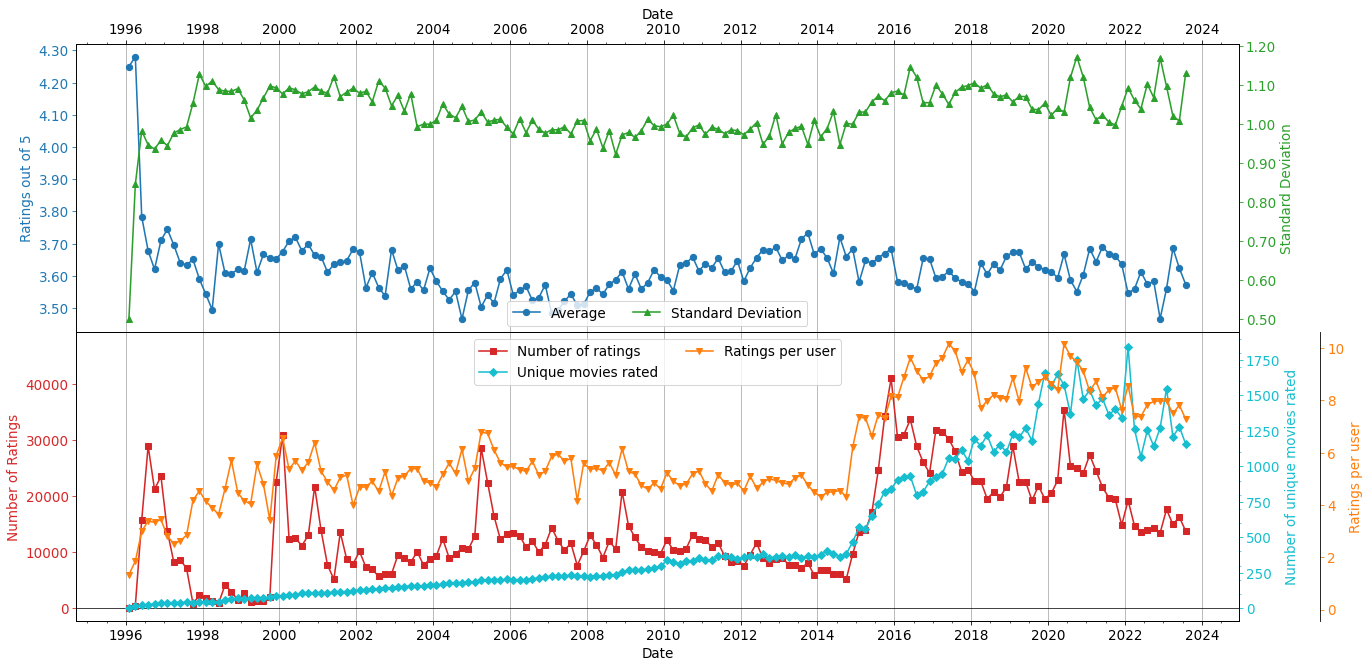

In [8]:
grouped = anim_df.groupby(pd.Grouper(freq='2M', key='date'))
df = grouped['rating'].describe()
df['uniqueMovies'] = grouped['title'].nunique()
df['uniqueUsers'] = grouped['userId'].nunique()
df['ratingsPerUser'] = df['count'] / df['uniqueUsers']
fig = plt.figure(1, figsize=(20,10), dpi=75)
# average and standard deviation
ax = fig.add_subplot(211)
twin1 = ax.twinx()
xdata = [x.year+x.month/12 for x in df.index]
p1, = ax.plot(xdata, df['mean'], color='tab:blue',
              label='Average', marker='o')
p2, = twin1.plot(xdata, df['std'], color='tab:green',
                 label='Standard Deviation', marker='^')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
ax.legend(handles=[p1, p2], loc='lower center', ncol=2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.grid(axis='x')
ax.set_ylabel('Ratings out of 5', color=p1.get_color())
twin1.set_ylabel('Standard Deviation', color=p2.get_color())
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
twin1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.set_xlabel('Date')
# number of votes and distinct movies voted for
ax = fig.add_subplot(212)
twin1 = ax.twinx()
twin2 = ax.twinx()
ax.axhline(0, color='k', linewidth=0.7)
p1, = ax.plot(xdata, df['count'], color='tab:red',
              label='Number of ratings', marker='s')
p2, = twin1.plot(xdata, df['uniqueMovies'], color='tab:cyan',
                 marker='D', label='Unique movies rated')
p3, = twin2.plot(xdata, df['ratingsPerUser'], marker='v',
                color='tab:orange', label='Ratings per user')
twin2.spines.right.set_position(("axes", 1.07))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
twin1.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.legend(handles=[p1, p2, p3], loc='upper center', ncol=2)
ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color(), which='both')
twin2.tick_params(axis='y', colors=p3.get_color(), which='both')
ax.grid(axis='x')
ax.set_ylabel('Number of Ratings', color=p1.get_color())
twin1.set_ylabel('Number of unique movies rated', color=p2.get_color())
twin2.set_ylabel('Ratings per user', color=p3.get_color())
align_y_axis(ax, twin2)
align_y_axis(ax, twin1)
ax.set_xlabel('Date')
fig.subplots_adjust(hspace=0)

In [9]:
df.head(15)

,count,mean,std,min,25%,50%,75%,max,uniqueMovies,uniqueUsers,ratingsPerUser
date,,,,,,,,,,,
1996-01-31,4.0,4.250000,0.500000,4.0,4.0,4.0,4.25,5.0,2,3,1.333333
1996-03-31,438.0,4.280822,0.845582,1.0,4.0,4.0,5.00,5.0,16,237,1.848101
1996-05-31,15752.0,3.783329,0.982402,1.0,3.0,4.0,5.00,5.0,22,5254,2.998097
1996-07-31,28920.0,3.677663,0.946787,1.0,3.0,4.0,4.00,5.0,24,8549,3.382852
1996-09-30,21173.0,3.620413,0.935787,1.0,3.0,4.0,4.00,5.0,31,6349,3.334856
1996-11-30,23532.0,3.709969,0.958391,1.0,3.0,4.0,4.00,5.0,38,6831,3.444884
1997-01-31,13769.0,3.744644,0.944654,1.0,3.0,4.0,5.00,5.0,39,4900,2.810000
1997-03-31,8235.0,3.696296,0.976493,1.0,3.0,4.0,4.00,5.0,40,3266,2.521433
1997-05-31,8620.0,3.640951,0.986023,1.0,3.0,4.0,4.00,5.0,40,3294,2.616879


Here, we can see that there were not many ratings made for animated movies in 1996 and the
average ratings were quite high with a small sample size. After that small period, the average
ratings dropped significantly and remained fairly constant not changing greately even as the
number of unique movies rated and the ratings per user increased. But, this is showing the behavior
of all the movies that were available on or before the date the reviews were made. What about
how older animated movies have performed vs. newer ones?

## Average ratings of movies released in one calendar year

Here, I will try to show how older animated films compare to newer animated films. I am interested
in this as older movies had to be hand-drawn whereas newer movies rely much more on 3D animation
with the rise of computers and the decrease in cost of 3D animation. I will achieve this by taking
all the movies that were released in one calendar year and take the average of all the ratings
made for those animated movies. I am defining the calendar year just by the year that each movie
was released. So, if a movie was released in January of 1995 and another was released in December
of 1995 they will placed in the group of movies released in 1995.

In [10]:
contains = data_df['movies']['genres'].str.contains('Animation')
grouped = data_df['movies'][contains].groupby('releaseYear')
numAnimMovies = grouped['title'].count().sort_values(ascending=False)

In [11]:
grouped = anim_df.groupby('releaseYear')
df = grouped['rating'].describe(percentiles=[.1, .25, .5, .75, .9])
ratingByRelease = df

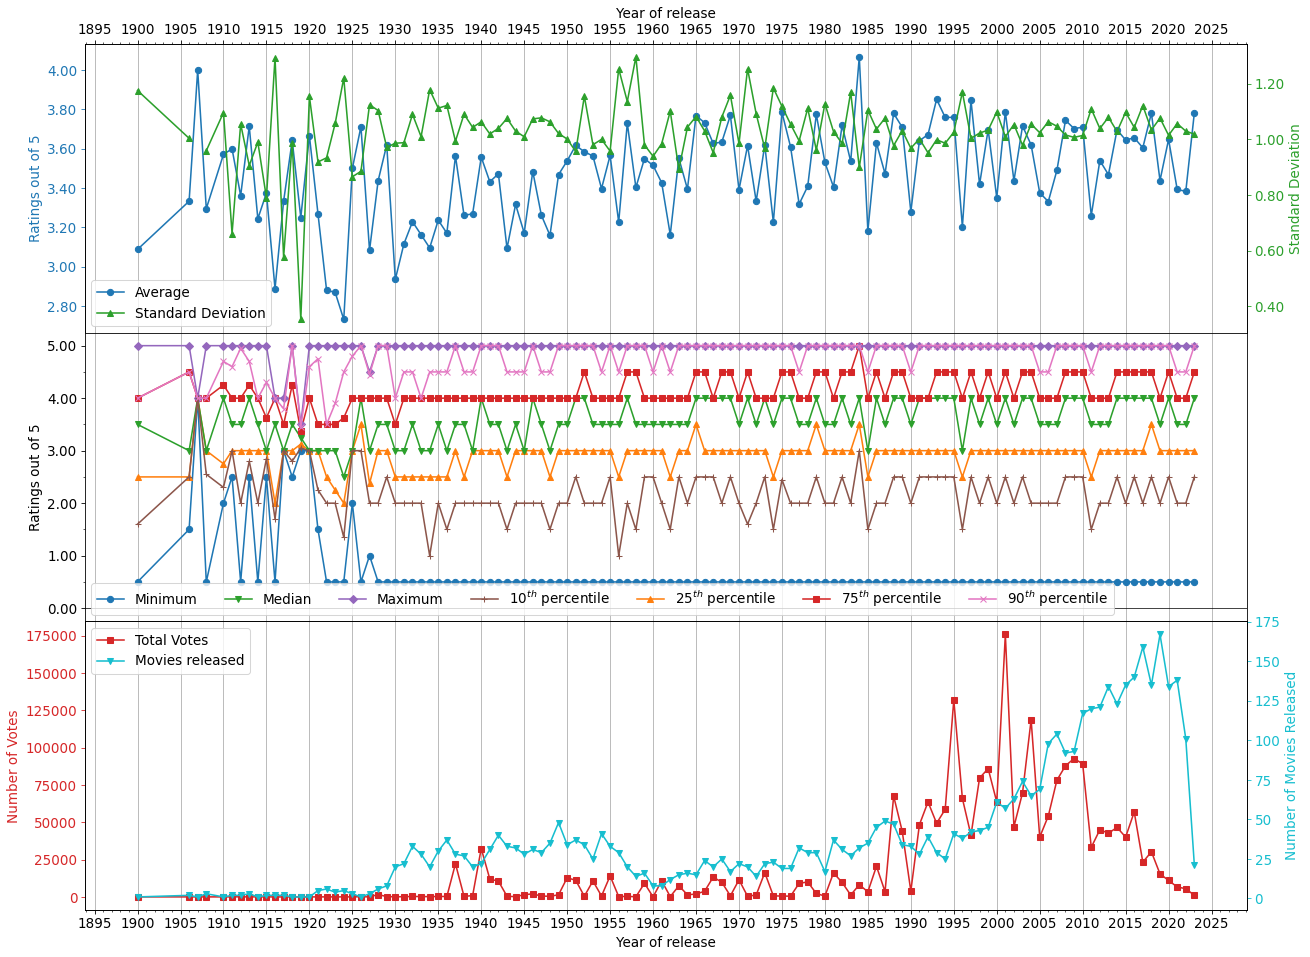

In [12]:
fig = generate_plot(ratingByRelease, 1, True, numAnimMovies)

In [13]:
highestCount = ratingByRelease.sort_values(by=['count'], ascending=False).index.values
ratingByRelease.sort_values(by=['count'], ascending=False).head(9)

,count,mean,std,min,10%,25%,50%,75%,90%,max
releaseYear,,,,,,,,,,
2001,175892.0,3.788248,1.010258,0.5,2.5,3.0,4.0,4.5,5.0,5.0
1995,131964.0,3.759938,1.025821,0.5,2.5,3.0,4.0,4.5,5.0,5.0
2004,118732.0,3.619854,1.055222,0.5,2.0,3.0,4.0,4.5,5.0,5.0
2009,92743.0,3.702824,1.007579,0.5,2.5,3.0,4.0,4.5,5.0,5.0
2010,89128.0,3.709693,1.014302,0.5,2.5,3.0,4.0,4.5,5.0,5.0
2008,87883.0,3.744797,1.016023,0.5,2.5,3.0,4.0,4.5,5.0,5.0
1999,85982.0,3.697914,1.033350,0.5,2.5,3.0,4.0,4.5,5.0,5.0
1998,79688.0,3.418520,1.023038,0.5,2.0,3.0,3.5,4.0,5.0,5.0
2007,78187.0,3.490158,1.047424,0.5,2.0,3.0,3.5,4.0,5.0,5.0


Here, we show a plot of the average all time ratings (blue line), the respective standard deviation (green line),
total number of ratings (red line), and number of animated movies released in that calendar year (cyan line).
What I can infer based on this data is that animated movies, irregardless of when they were released, seem to
actually have pretty consistent ratings oscillating around 3.4. The standard deviation is a bit all over the place
for animated movies released prior to 1930. The standard deviation becomes more consistent after 1930 and seems to
revolve around 1.0.

We can also see that the number of animated movies that have been released for each calendar
year have actually risen pretty dramatically from a maximum 50 from 1930 to 1955 to approximately 170 in 2019.
I suspect a lot of this has to do with the increase in computing power that creators have available which can
lead to lower production costs as the 3D animated movies at the end of the 20<sup>th</sup> century become more
common than their traditional counter parts that were hand-drawn.

## Study on individual years

Now what I want to look at is the data for the individual years instead of the entire span of time that there is
data available for. If we look at the plot the we generated above we can see that there are a few peaks in the
number of ratings made for animated movies that came out in 1988, 1995, 2001, 2004, and 2008 to 2010. What I'm
wondering is if there is any couple movies that were especially popular that came out in that time period that
may be significantly increasing the total number of votes. Along with that I want to see if those movies are
significantly affecting the average rating for that year.

So let's start with fetching the data that we need.

In [14]:
years = [1988, 1995, 2001, 2004, 2008, 2009, 2010]
data = anim_df[anim_df['releaseYear'].isin(years)].copy()
select_data = data.groupby('movieId')['rating'].describe() \
                .merge(data[['movieId', 'releaseYear', 'title']].drop_duplicates(),
                       on='movieId', how='left')
contains = data_df['movies']['genres'].str.contains('Animation')
percentTotal = select_data.groupby('releaseYear').apply(get_percent_of_total) \
                        .reset_index().set_index('level_1').drop('releaseYear', axis=1)
select_data['percentTotal'] = percentTotal

### Movies with the highest number of ratings

In [15]:
disp_cols = ['releaseYear', 'mean', 'std', 'count', 'percentTotal']
df = select_data.sort_values(by=['count'], ascending=False).groupby('releaseYear').head(5) \
        .sort_values(by=['releaseYear', 'count'], ascending=[True, False]).set_index('title')[disp_cols].copy()
df['count'] = df['count'].astype(int)
df.style.background_gradient(axis=0, gmap=df['releaseYear'])

,releaseYear,mean,std,count,percentTotal
title,,,,,
Who Framed Roger Rabbit? (1988),1988,3.543433,0.949754,26627,39.398961
My Neighbor Totoro (Tonari no Totoro) (1988),1988,4.163490,0.858451,14010,20.730065
Akira (1988),1988,3.934376,0.937954,12122,17.936463
Grave of the Fireflies (Hotaru no haka) (1988),1988,4.101209,0.911399,6946,10.277733
Oliver & Company (1988),1988,3.316730,0.949151,3443,5.094476
Toy Story (1995),1995,3.893508,0.929105,76813,58.207541
Pocahontas (1995),1995,2.978704,1.074605,17562,13.308175
Wallace & Gromit: A Close Shave (1995),1995,4.096216,0.976068,14587,11.053772
Ghost in the Shell (Kôkaku kidôtai) (1995),1995,3.990715,0.905179,10986,8.324998


### Movies with the lowest number of ratings

In [16]:
disp_cols = ['releaseYear', 'mean', 'std', 'count', 'percentTotal']
df = select_data.sort_values(by=['count'], ascending=False).groupby('releaseYear').tail(5) \
        .sort_values(by=['releaseYear', 'count'], ascending=[True, False]).set_index('title')[disp_cols].copy()
df['count'] = df['count'].astype(int)
df.style.background_gradient(axis=0, gmap=df['releaseYear'])

,releaseYear,mean,std,count,percentTotal
title,,,,,
Urusei Yatsura: The Final Chapter (1988),1988,2.500000,nan,1,0.001480
Tokyo The Last Megalopolis (1988),1988,3.000000,nan,1,0.001480
Winter (1988),1988,2.500000,nan,1,0.001480
Self Portrait (1988),1988,3.500000,nan,1,0.001480
Snoopy: The Musical (1988),1988,2.000000,nan,1,0.001480
Pib and Pog (1995),1995,4.000000,0.000000,2,0.001516
Achilles (1995),1995,2.500000,1.414214,2,0.001516
Landlock (1995),1995,3.000000,nan,1,0.000758
Legend of Crystania: The Motion Picture (1995),1995,3.000000,nan,1,0.000758


Clearly, we can see that there are certain years where one movie in particular was extremely popular
and the votes were heavily weighted to that one movie. A prime example of this would be *Toy Story (1995)*
which received over 58% of the total ratings cast for movies that were released in that year. So does
this then say that we should be weighing the average ratings for movies for a specific year differently?

What I will now try to do is to remove the dependence on the popularity (number of ratings) of a certain
movie and get an average of the movies for a specific year irregardless of the number of ratings made.
I believe this will be a more accurate representation of how animated films have performed during a
specific calendar year as it weighs the most popular and unpopular movies evenly.

## Analysis on the average of the average

Here, what I will do is get an average of all the available ratings for each movie separately and then group
the movies by the release year and get the average of the average ratings for movies released each
calendar year.

In [17]:
tmp = anim_df.copy()
cols = ['movieId', 'releaseYear', 'title']
avgRatings = tmp.groupby('movieId')['rating'].describe() \
        .merge(anim_df[cols].drop_duplicates(), on='movieId', how='left') \
        .groupby('releaseYear')['mean'].describe(percentiles=[.1, .25, .5, .75, .9])

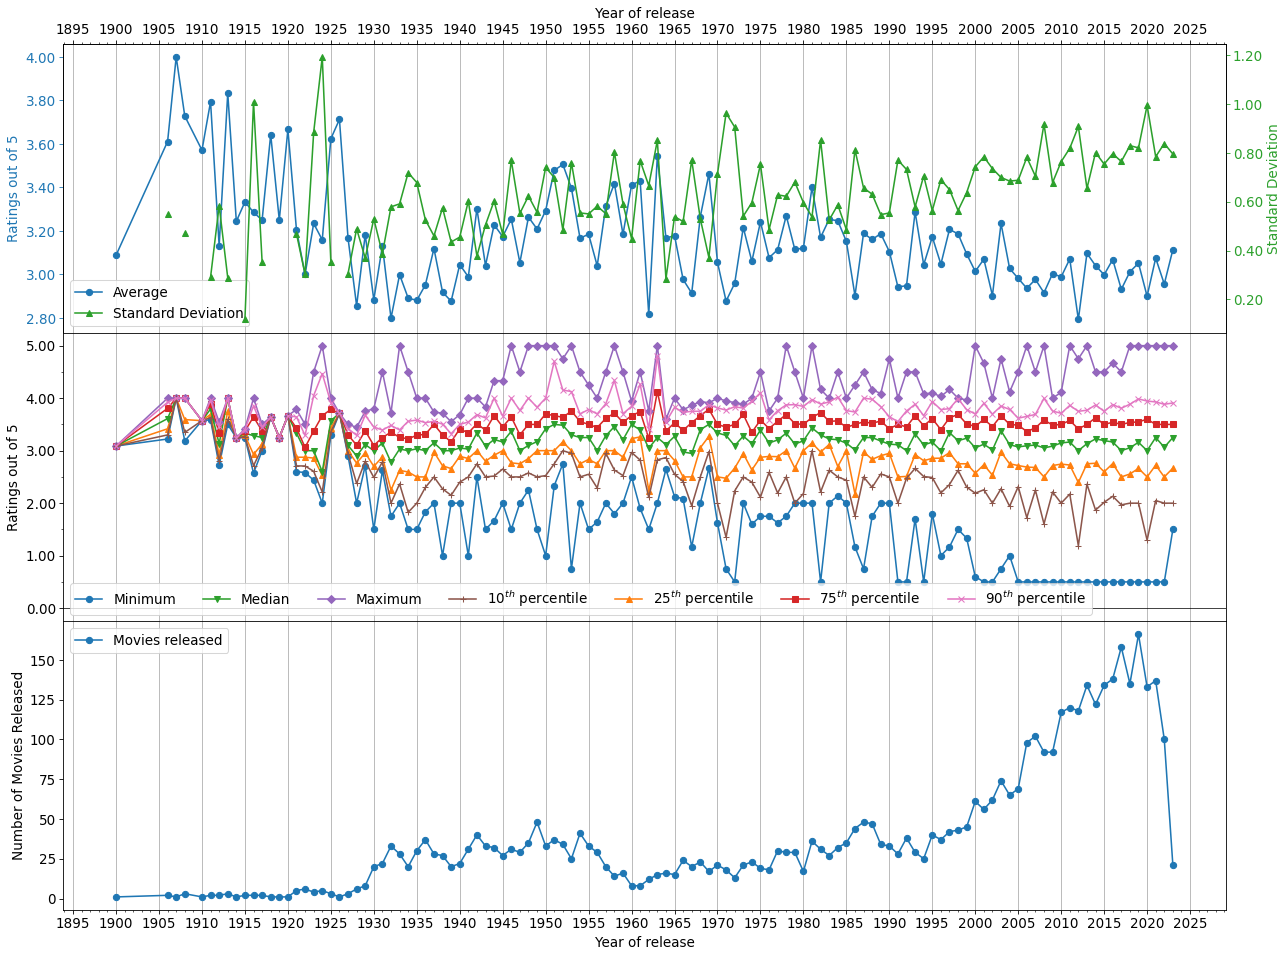

In [18]:
fig = generate_plot(avgRatings, 2, False)

What we can see, comparing to the previous figure, is that overall the average goes down slightly.
This could come from how the median drops from 4 to approximately 3 and the minimum value having
a steady decrease over the years. However, the 25<sup>th</sup> and 75<sup>th</sup> percentiles
stay fairly close to the median not exceeding a value less than or greater than 0.5, respectively.
Also, the 10<sup>th</sup> and 90<sup>th</sup> percentiles are a bit further apart from the
minimum and maximum, respectively, which seems to point to a more evenly distributed data set.

Overall, I believe that this gives a much better description of how animated films have performed
as we have removed the popularity bias from the data. However, we are also giving more power to
those who rated unpopular movies, so the opinions of those people seem to have more power which
opens up the trends to their bias.

## Conclusion

My final conclusion, based on this data, is that animated actually seem to have performed farily
well throughout the years. It would be interesting to see if there is a way to group the movies
based on the studio that produced them, such as, Pixar, Dreamworks, Disney (before acquiring
Pixar), and Studio Ghibli, and see how they have performed individually.

As with any other data set, there is no perfect method that
one can use to interpret results and overall trends, but as long we do our due dilligence and try
to take into account all the factors that can affect data and test the different methods we
should be able to draw reasonable conclusions on the data. Thank you for coming along with me
on this magical journey and I hope that you enjoyed this small analysis that I have made on the
overall progress of animated movies throughout the years.